### Introduction
The goal of this analysis is to explore the impact of climate on corn yields. The drivers of corn yields variability include but not limit to climate, technology, fertilizer application and soil management. Firstly, county-level corn yields are adjusted to account for all other non-climate confounders. Then a GBM model is built to estimate the effect of climate factors on corn production. Last but not least, several important climate factors are identified.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence

### Data Prep 
To account for the effect of all non-climate factors on corn production, a simple linear regression model is built at county level for every county, with corn yield being the dependent variable and time(year) being the independent variable. Non-climate factors include technology, fertilizer application and soil management. Time can be seen as a proxy for these factors because these factors usually progress as time goes by. The fitted yields are subtracted from original values.

In [3]:
common_data = pd.read_csv("./common_data.csv")
daily_obs = pd.read_csv("./daily_observations.csv")
annual_yields = pd.read_csv("./annual_yields.csv")

In [4]:
def get_fitted_yield(df):
    temp = df.loc[df['yield'].notna()]
    lr = LinearRegression().fit(np.array(temp['year']).reshape((-1, 1)), temp['yield'])
    return pd.Series(lr.predict(np.array(df['year']).reshape((-1, 1))).round(1), index=df['year'], name='fitted_yield')

In [5]:
fitted_yield = common_data.groupby('adm2_code').apply(get_fitted_yield).reset_index()

common_data = pd.merge(common_data, fitted_yield, how = 'inner', on = ['adm2_code', 'year'])

In [6]:
common_data['yield_residual'] = common_data['yield'] - common_data['fitted_yield']

In [22]:
temp = common_data.loc[common_data['adm2_code'] == 'US01049'][['year', 'yield']]
temp.dropna(axis=0, inplace=True)
lr = LinearRegression()
lr.fit(np.array(temp['year']).reshape((-1, 1)), temp['yield'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

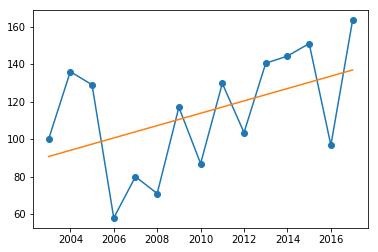

In [27]:
plt.scatter(temp['year'], temp['yield'])
plt.plot(temp['year'], temp['yield'])
plt.plot(np.arange(2003, 2018), lr.predict(np.arange(2003, 2018).reshape((-1, 1))))

### Feature Engineering
Climate features are aggregated at county level. Firstly, daily observations not in growing season are removed from the data set. For each climate factor, the minimum/maximum/mean/sum values during growing seasons are recorded, if appropriate.

In [7]:
obs = pd.merge(daily_obs, common_data, how = 'left', on = ['year', 'adm2_code'])

obs = obs.loc[(obs['doy'] >= obs['phen_gup']) & (obs['doy'] <= obs['phen_dor'])]

In [8]:
obs = obs.groupby(['adm2_code', 'year']).\
          agg({'met_avg_t': [np.min, np.max, np.mean], 
               'met_extreme_cold': np.sum,
               'met_extreme_hot1': np.sum,
               'met_extreme_hot2': np.sum,
               'met_gdd': np.sum,
               'met_max_rh': [np.min, np.max, np.mean],
               'met_max_t': [np.min, np.max, np.mean],
               'met_max_vpd': [np.min, np.max, np.mean],
               'met_min_t': [np.min, np.max, np.mean],
               'met_p_mm': [np.max, np.mean],
               'met_sh': [np.min, np.max, np.mean],
               'met_sr_wm2': np.sum,
               'mod_evi': np.mean,
               'mod_lst_day': [np.min, np.max, np.mean],
               'mod_lst_night': [np.min, np.max, np.mean],
               'mod_nbar_1': [np.min, np.max, np.mean],
               'mod_nbar_2': [np.min, np.max, np.mean],
               'mod_nbar_3': [np.min, np.max, np.mean],
               'mod_nbar_4': [np.min, np.max, np.mean],
               'mod_nbar_5': [np.min, np.max, np.mean],
               'mod_nbar_6': [np.min, np.max, np.mean],
               'mod_nbar_7': [np.min, np.max, np.mean],
               'mod_ndvi': [np.min, np.max, np.mean]})

In [9]:
obs.columns = ['_'.join(x).strip('_') for x in obs.columns.ravel()]
obs.reset_index(inplace=True)

In [10]:
obs.sort_values(['adm2_code', 'year'], inplace=True)

In [3]:
# common_data.to_csv("./common_data_ver02.csv")
# obs.to_csv("./obs.csv")

# common_data = pd.read_csv("./common_data_ver02.csv")
# obs = pd.read_csv("./obs.csv")
df = pd.merge(common_data, obs, on = ['adm2_code', 'year'])

# df.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis = 1, inplace=True)

In [4]:
df.head()

,adm2_code,adm1_code,year,yield,area_harvested_obs,phen_gup,phen_dor,fitted_yield,yield_residual,met_avg_t_amin,...,mod_nbar_5_mean,mod_nbar_6_amin,mod_nbar_6_amax,mod_nbar_6_mean,mod_nbar_7_amin,mod_nbar_7_amax,mod_nbar_7_mean,mod_ndvi_amin,mod_ndvi_amax,mod_ndvi_mean
0,US01031,US01,2003,123.0,5500.0,72,295,103.6,19.4,279.29572,...,0.383032,0.242370,0.359690,0.294719,0.11175,0.234810,0.167882,0.453069,0.728950,0.582226
1,US01031,US01,2004,111.0,6900.0,72,295,102.3,8.7,280.42957,...,0.381888,0.244594,0.372859,0.305693,0.11848,0.258459,0.178722,0.394642,0.746574,0.567168
2,US01031,US01,2005,127.0,6000.0,72,295,101.1,25.9,283.24622,...,0.380605,0.237850,0.360430,0.293601,0.09699,0.249910,0.166506,0.420422,0.785504,0.585358
3,US01031,US01,2006,85.0,5600.0,72,295,99.9,-14.9,279.67178,...,0.386895,0.252522,0.376950,0.314021,0.12675,0.267500,0.202066,0.410391,0.724180,0.535076
4,US01031,US01,2007,73.0,8300.0,72,295,98.6,-25.6,278.24840,...,0.383400,0.256090,0.379590,0.306551,0.13142,0.266640,0.186277,0.409932,0.725044,0.553988


In [5]:
df_2018 = df.loc[df['year'] == 2018]
df = df.loc[df['year'] != 2018]

### Modeling
A GBM model is built to predict 'yield_residual'. GBM is picked for its good performance and its ability to model interactions between different climate factors. Grid search is used to find optimal combination of hyper-parameters. When building a model, 5-fold cross validation is used to reduce overfitting. The best-performing model is evaluated on a hold-out data set for model assessment. The performance of linear regression plus GBM is compared to two benchmark models: 1) multiple linear regression model 2) GBM

When tuning the hyper-parameters of a gbm model, for the time constraint, only n_estimators(number of trees) and max_depth(maximum depth of each tree) are tuned in this analysis. In general, other tree specific parameters can also be included. Since GBM is known to be difficult to train, more training time is needed in order to find the optimal hyper-parameters.

In [6]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 6)

In [16]:
parameters = {'n_estimators': [50, 100, 200, 300, 400, 500],
              'max_depth': [3, 4, 5]}

gbm_reg = GradientBoostingRegressor(loss = 'ls', learning_rate = 0.05, 
                                    criterion = 'friedman_mse')

grid_search = GridSearchCV(estimator = gbm_reg, param_grid = parameters, 
                           scoring = 'neg_mean_squared_error', 
                           n_jobs = -1, verbose = 1, cv = 5, return_train_score = True)

grid_search.fit(X = df_train.iloc[:, 9:df_train.shape[1]], 
                y = df_train.iloc[:, 8])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 20.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200, 300, 400, 500], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [17]:
grid_search.best_params_

{'max_depth': 5, 'n_estimators': 500}

In [16]:
best_gbm = GradientBoostingRegressor(n_estimators = 500,  loss = 'ls', 
                                     learning_rate = 0.05, 
                                     criterion = 'friedman_mse', max_depth = 5)

best_gbm.fit(X = df_train.iloc[:, 9:df_train.shape[1]], y = df_train.iloc[:, 8])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

Evaluating the model on both training set and hold-out set shows that the model overfits training data.

In [17]:
mse_train = mean_squared_error(y_true=df_train.iloc[:,8], y_pred=best_gbm.predict(X = df_train.iloc[:,9:df_train.shape[1]]))
mse_test = mean_squared_error(y_true=df_test.iloc[:,8], y_pred=best_gbm.predict(X = df_test.iloc[:,9:df_test.shape[1]]))
print("mse on training set: {}, mse on testing set: {}".format(mse_train, mse_test))

mse on training set: 72.97545788420813, mse on testing set: 157.8512792487591


The first baseline model is a multiple linear regression model. The county level yields (without adjusting for non-climate factors) are regressed on all climate variables. Result shows that the predictive model reduces mse by 54%. 

In [34]:
lr = LinearRegression().fit(df_train.iloc[:, 9:df_train.shape[1]], df_train['yield'])
lr_pred = pd.Series(lr.predict(df_test.iloc[:, 9:df_test.shape[1]]), index=df_test['year'], name='fitted_yield')

mse_benchmark_mlr = mean_squared_error(y_true=df_test['yield'], y_pred=lr_pred)

In [42]:
mse_slr_gbm = mean_squared_error(y_true=df_test.iloc[:,3], y_pred=df_test.iloc[:,7] + best_gbm.predict(X = df_test.iloc[:, 9:df_test.shape[1]]))

print("MSE of predictive model is {}".format(mse_slr_gbm))
print("MSE of benchmark mlr model is {}".format(mse_benchmark_mlr))
print("The predictive reduces mse by {}%".format(round((1 - mse_slr_gbm/mse_benchmark_mlr) * 100), 2))

MSE of predictive model is 157.8512792487591
MSE of benchmark model is 339.5625731142493
The predictive reduces mse by 54.0%


The second baseline model is a GBM model. The county level yields (without adjusting for non-climate factors) are regressed on all climate variables. Result shows that the predictive model reduces mse by 23%.

In [44]:
parameters = {'n_estimators': [100, 300, 500],
              'max_depth': [3, 4, 5]}

gbm_reg = GradientBoostingRegressor(loss = 'ls', learning_rate = 0.05, 
                                    criterion = 'friedman_mse')

grid_search = GridSearchCV(estimator = gbm_reg, param_grid = parameters, 
                           scoring = 'neg_mean_squared_error', 
                           n_jobs = -1, verbose = 1, cv = 5, return_train_score = True)

grid_search.fit(X = df_train.iloc[:, 9:df_train.shape[1]], 
                y = df_train.iloc[:, 3])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 10.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 300, 500], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [45]:
grid_search.best_params_

{'max_depth': 5, 'n_estimators': 500}

In [46]:
benchmark_gbm = GradientBoostingRegressor(n_estimators = 500,  loss = 'ls', 
                                     learning_rate = 0.05, 
                                     criterion = 'friedman_mse', max_depth = 5)

benchmark_gbm.fit(X = df_train.iloc[:, 9:df_train.shape[1]], y = df_train.iloc[:, 3])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [49]:
mse_benchmark_gbm = mean_squared_error(y_true=df_test.iloc[:,3], y_pred=benchmark_gbm.predict(X = df_test.iloc[:, 9:df_test.shape[1]]))

print("MSE of predictive model is {}".format(mse_slr_gbm))
print("MSE of benchmark GBM model is {}".format(mse_benchmark_gbm))
print("The predictive reduces mse by {}%".format(round((1 - mse_slr_gbm/mse_benchmark_gbm) * 100), 2))

MSE of predictive model is 157.8512792487591
MSE of benchmark GBM model is 204.07953727183948
The predictive reduces mse by 23.0%


### Insights and discussion
Important variables in predicting corn yields are identified by examing feature importance. To understand the marginal effect of one or two features on corn yields, a partial dependence plot can be used.

The most important features in predicting corn yields are: 

1) maximum temperature, which might be a indicator of hot weather.

2) mean value of observed specific humidity

3) sum of growing degree days

4) maximum value of average temperature

5) mean value of observed precipitation

The marginal effects of these variables can be deduced from partial dependence plots. For example, in the 5th graph, it shows that when taking into account of all other climate factors, more precipitation generally leads to higher corn yields. But as long as precipitation level is above a threshold, precipitation seems to have very little marginal effect on corn yields.

The 6th figure shows an example of how the interaction between two climate factors would affect corn yield, when the effect of all other variables are taken into account. The highest level of yield is attained when the mean value of specific humidity is between 0.0105 and 0.0125 and maximum temperature is between 307 and 311. 

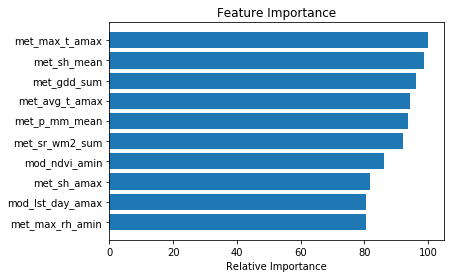

In [27]:
names = df.columns[9:]
feature_importance = best_gbm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1]
pos = np.arange(sorted_idx.shape[0])[::-1] + .5
plt.barh(pos[:10], feature_importance[sorted_idx[:10]], align='center')
plt.yticks(pos[:10], names[sorted_idx[:10]])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

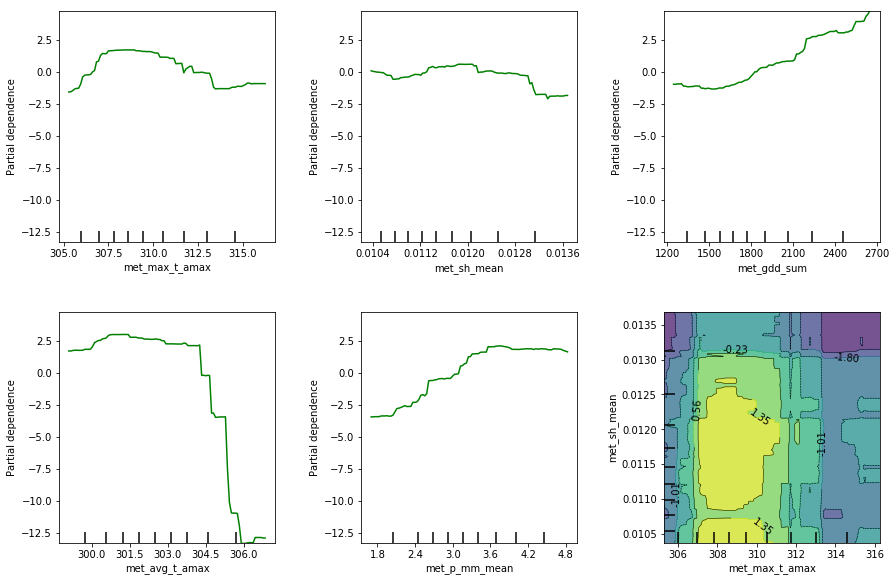

In [32]:
features = list(sorted_idx[:5]) + [(sorted_idx[0], sorted_idx[1])]
fig, axs = plot_partial_dependence(best_gbm, df_train.iloc[:, 9:df_train.shape[1]], features, feature_names=names, grid_resolution=100)
plt.subplots_adjust(top = 2, right = 2) 
plt.show()

### Predicting 2018 corn yields
Firstly, 2018 data is fed into GBM to predict the residuals. Then the result is added to the fitted_yield from simple linear regression.

In [41]:
df_2018['yield'] = best_gbm.predict(df_2018.iloc[:,9:]) + df_2018['fitted_yield']

In [45]:
df_2018[['adm2_code', 'adm1_code', 'year', 'yield']]

,adm2_code,adm1_code,year,yield
9,US01031,US01,2018,71.465585
24,US01033,US01,2018,155.870370
40,US01049,US01,2018,140.426347
56,US01071,US01,2018,127.208916
72,US01077,US01,2018,156.292699
88,US01079,US01,2018,148.010020
104,US01083,US01,2018,147.229080
120,US01089,US01,2018,173.467302
133,US01121,US01,2018,147.793957
143,US05001,US05,2018,190.458745


### Some ideas on improving model performance

1) To better estimate the effect of all non-climate variables on yields, we can try to find better proxies (other than time) and include them in linear regression.

2) The GBM has overfitting problem. One idea to reduce overfitting is to further limit the depth of each tree and also decrease the learning rate. The idea is that by decreasing the depth, each tree will learn less from training data. Smaller learning rate will shrink the contribution of each tree in the final prediction. In both ways, we try to reduce the influence of a single tree on final prediction.

3) More features can be created by aggregating daily observations on week or month level. The idea is that some time periods in growing season might be more important than others in yields prediction.

3) By building a sequence model (RNN), the temporal info might be captured.

5) Both 4 and 5 will enable real time prediction. The model can make prediction on this year's yield at any time point in this year, even with incomplete data. 